# Titanic Survival Predictions Final Project 
 Yashwee Kothari and Vanshika Shah 

1. https://www.kaggle.com/c/titanic/data?select=test.csv

2. Top 10% teams worldwide as of 11:59pm on Dec 14, 2021 will get A in this class.

3. Feature engineering: create new features from the raw data

4. Supervised learning models: Choose 2 supervised learning models from W3, W4, W5

5. Advanced models: choose 1 from XGBoost W12 or Neural Network W13 or Deep learning W14 to build your supervised learning models

6. Model evaluation: For each of the supervised learning models, evaluate the model using the techniques from W10

7. If data size is too big and your model is too slow, feel free to choose small set for your project.

8. Your jupyter submission should be in an article quality. Do NOT print huge data set in the notebook. Use head(). Use 

9. Plotting to visualize your analysis and results. Use markdown to write your comments.

10. If you are not in the top 10% teams worldwide, your score is based on completeness on every step as described above. Submit in HTML and ipynb format on canvas

In [1]:
#!pip install xgboost
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
%matplotlib inline
from sklearn import neighbors, preprocessing, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, ExtraTreeClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve


In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

### Feature Engineering

In [4]:
#filling empty data in columns age, Cabin, Embarked
data.fillna(method='pad', inplace=True)
data.bfill(inplace=True)
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [5]:
#Age Bins 
bins = [ x for x in range(0, 90, 10 ) ] 
data['Age_Bins'] = pd.cut( x=data['Age'], bins=bins, labels=['0s','10s','20s', '30s', '40s','50s','60s', '70s'])

#Total Number of Family Members on Titanic 
data['Family_Members'] = data['SibSp'] + data['Parch']

#Create Labels for Class to String format (ex: 1=First Class)
data['Class_Bins'] = pd.cut( x=data['Pclass'], bins=[0,1,2,3], labels=['First Class', 'Second Class', 'Third Class'])

#Aggregate Pclass with mean age and total family members on deck 
classes_age=data.groupby('Pclass').median()[['Age']].rename(columns={'Age':'Median_Class_Age'})
classes_fam = data.groupby('Pclass').mean()[['Family_Members']].rename(columns={'Family_Members':'Mean_Class_Family'})
data = pd.merge(pd.merge(data, classes_age, on='Pclass'), classes_fam, on='Pclass')


data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Bins,Family_Members,Class_Bins,Median_Class_Age,Mean_Class_Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,C85,S,20s,1,Third Class,25.0,1.008147
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C85,S,20s,0,Third Class,25.0,1.008147
2,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C123,S,30s,0,Third Class,25.0,1.008147
3,6,0,3,"Moran, Mr. James",male,35.0,0,0,330877,8.4583,C123,Q,30s,0,Third Class,25.0,1.008147
4,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,E46,S,0s,4,Third Class,25.0,1.008147


The new features we created are age bins, total number of family members on the Titanic, bins for ticket class, and aggregating the mean and median data by class. 

Age bins can tell us at a glance which age range, by decade, they belong in (ex: 20s, 30s, 40s...) 

We chose to aggregate the mean and median data for age and family members onboard by Pclass because this can tell us more statistics specifically as it relates to their class. 

We also chose to combine the total number of spouses/siblings and number of parents/children, as this number tells us the total amount of family members that a passenger had aboard.

In [6]:
copy_df = pd.get_dummies(data["Sex"], columns=['Sex'],  prefix='Sex')
data = data.join(copy_df)

In [7]:
copy_df = pd.get_dummies(data["Embarked"], columns=['Embarked'],  prefix='Embarked')
data = data.join(copy_df)

In [8]:
data['Cabin'] = data['Cabin'].map(lambda x: x.lstrip('C'))
copy_df = pd.get_dummies(data["Cabin"], columns=['Cabin'],  prefix='Cabin')
data = data.join(copy_df)

In [9]:
copy_df = pd.get_dummies(data["Class_Bins"], columns=['Class_Bins'],  prefix='Class_Bins')
data = data.join(copy_df)

In [10]:
copy_df = pd.get_dummies(data["Age_Bins"], columns=['Age_Bins'],  prefix='Age_Bins')
data = data.join(copy_df)



In [11]:
data = data.drop("Sex",1)
data = data.drop("Name",1)
data = data.drop("Ticket",1)
data = data.drop("Cabin",1)
data = data.drop("Embarked",1)
data = data.drop("Age_Bins",1)
data = data.drop("Class_Bins",1)

### Supervised Learning Algorithm #1 KNN

In [12]:
# KNN Algorithm 
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred=knn.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.80      0.75       114
           1       0.54      0.42      0.47        65

    accuracy                           0.66       179
   macro avg       0.62      0.61      0.61       179
weighted avg       0.65      0.66      0.65       179



AUC - Test Set: 60.85%


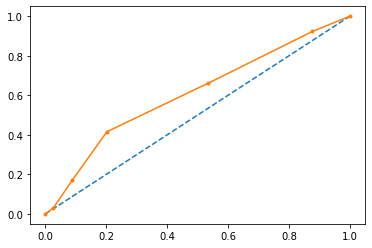

In [13]:
#AUC for KNN

probs_y=knn.predict_proba(X_test) 
probs_y


# keep probabilities for the positive outcome only
probs = probs_y[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

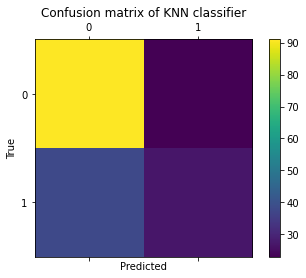

In [14]:
labels = ['0', '1']
cm = confusion_matrix(y_test, y_pred)
cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of KNN classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Supervised Learning Algorithm #2 Decision Tree

In [15]:

X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
tree = tree.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       106
           1       0.80      0.64      0.71        73

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



AUC - Test Set: 86.44%


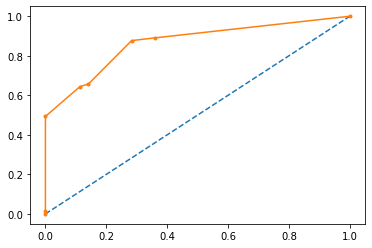

In [16]:
probs_y=tree.predict_proba(X_test) 
probs_y



# keep probabilities for the positive outcome only
probs = probs_y[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

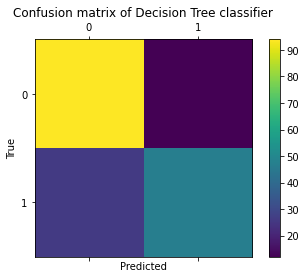

In [17]:
labels = ['0', '1']
cm = confusion_matrix(y_test, y_pred)
cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of Decision Tree classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Advanced Supervised Learning Model XGBoost

In [18]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=3)

model=xgb.XGBClassifier(subsample=0.5,colsample_bytree=0.5,min_child_weight=2,max_depth=6,learning_rate=0.15,n_estimators=100)


model.fit(X_train, y_train)
y_preds = model.predict(X_test)

print(classification_report(y_test, y_preds))

[16:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       162
           1       0.85      0.74      0.79       106

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268



AUC - Test Set: 86.29%


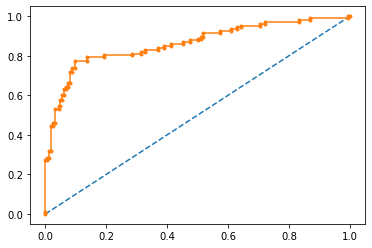

In [19]:
probs_y=model.predict_proba(X_test) 
probs_y


# keep probabilities for the positive outcome only
probs = probs_y[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

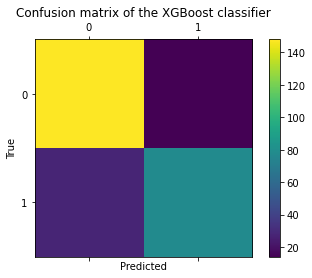

In [20]:
labels = ['0', '1']
cm = confusion_matrix(y_test, y_preds)
cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the XGBoost classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### XGB Model Visualizations

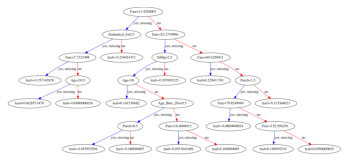

In [21]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 500]
plt.show()

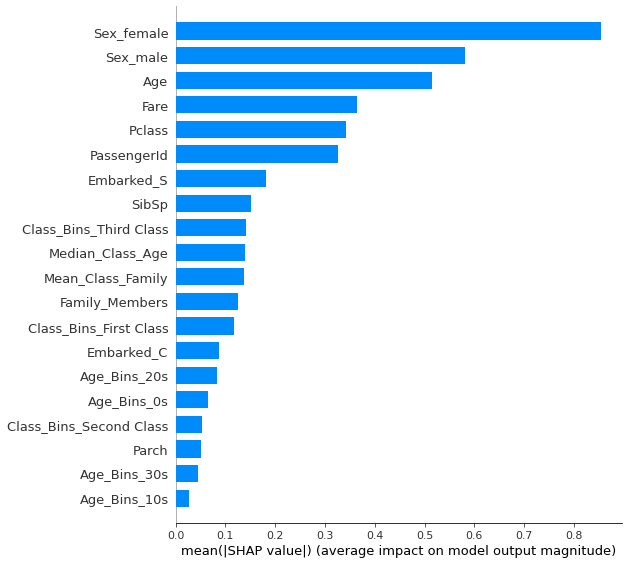

In [22]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Analysis

From the shapley plot from XGB model, we can see that the top features that were important in determining if someone survived were if you were female, what class ticket you bought, and your age. This makes sense, as females and children were put onto lifeboats first, and if you were rich and bought a Second or Third Class Ticket, you did not drown first. 

Out of all the classifiers we used: KNN, Decision Trees, and XGBoost, XGBoost performed the best at 84% accuracy. This finding makes sense because XGBoost trees are grown one after another and it attempts to reduce the misclassification rate are made in subsequent iterations. XGBoost is an advanced version of gradient boosting. This means that at its core XGBoost is sequentially adding predictors, each one correcting its predecessor's errors. It tries to fit the new predictor tree to the residual errors made by the previous predictor. 